In [24]:
import datetime as dt

import backtrader as bt
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

from stockdatamanage.db import engine

### 读取数据

In [60]:
# 沪深300指数数据
sql = 'select trade_date, close from index_daily where code="399300" and trade_date>="20130101"'
df = pd.read_sql(sql, engine, parse_dates=['trade_date'])
df['high'] = 0
df['low'] = 0
df['open'] = 0
df['volumn'] = 0
df['openinterest'] = 0
df = df[['trade_date', 'open', 'high', 'low', 'close', 'volumn', 'openinterest']]

# 沪深300滚动PE
sql = 'select trade_date, pe from index_dailyindicator where code="399300.SZ" and trade_date>="20130101"'
pedf = pd.read_sql(sql, engine, parse_dates=['trade_date'])
df = df.merge(pedf, how='left', on='trade_date')

df.rename(columns={'trade_date': 'datetime'}, inplace=True)
df.set_index('datetime', inplace=True)
df

,open,high,low,close,volumn,openinterest,pe
datetime,,,,,,,
2013-01-04,0,0,0,2524.41,0,0,10.96
2013-01-07,0,0,0,2535.99,0,0,10.97
2013-01-08,0,0,0,2525.33,0,0,10.90
2013-01-09,0,0,0,2526.13,0,0,10.90
2013-01-10,0,0,0,2530.57,0,0,10.94
...,...,...,...,...,...,...,...
2022-11-08,0,0,0,3749.33,0,0,10.88
2022-11-09,0,0,0,3714.27,0,0,10.79
2022-11-10,0,0,0,3685.69,0,0,10.74


In [91]:
# 沪深300指数数据(本代码格仅测试用， 用后即删)
sql = 'select trade_date, close from index_daily where code="399300" and trade_date>="20130101"'
dfa = pd.read_sql(sql, engine, parse_dates=['trade_date'])
print(type(dfa.trade_date[0]), dfa.trade_date[0])
dfb = pd.read_sql(sql, engine)
print(type(dfb.trade_date[0]), dfb.trade_date[0])

<class 'pandas._libs.tslibs.timestamps.Timestamp'> 2013-01-04 00:00:00
<class 'datetime.date'> 2013-01-04


In [26]:
def quantile_rate(x):
    return int(len(x[x<=x.iloc[-1]]) / len(x) * 100)

In [27]:
# 计算PE百分位
df['quantile'] = df['pe'].rolling(window=600).apply(quantile_rate)
df

,open,high,low,close,volumn,openinterest,pe,quantile
datetime,,,,,,,,
2013-01-04,0,0,0,2524.41,0,0,10.96,NaN
2013-01-07,0,0,0,2535.99,0,0,10.97,NaN
2013-01-08,0,0,0,2525.33,0,0,10.90,NaN
2013-01-09,0,0,0,2526.13,0,0,10.90,NaN
2013-01-10,0,0,0,2530.57,0,0,10.94,NaN
...,...,...,...,...,...,...,...,...
2022-11-08,0,0,0,3749.33,0,0,10.88,1.0
2022-11-09,0,0,0,3714.27,0,0,10.79,1.0
2022-11-10,0,0,0,3685.69,0,0,10.74,1.0


In [28]:
df['q0'] = df.pe.rolling(600).quantile(0)
df['q25'] = df.pe.rolling(600).quantile(.25)
df['q75'] = df.pe.rolling(600).quantile(.75)
df['q100'] = df.pe.rolling(600).quantile(1)
df

,open,high,low,close,volumn,openinterest,pe,quantile,q0,q25,q75,q100
datetime,,,,,,,,,,,,
2013-01-04,0,0,0,2524.41,0,0,10.96,NaN,NaN,NaN,NaN,NaN
2013-01-07,0,0,0,2535.99,0,0,10.97,NaN,NaN,NaN,NaN,NaN
2013-01-08,0,0,0,2525.33,0,0,10.90,NaN,NaN,NaN,NaN,NaN
2013-01-09,0,0,0,2526.13,0,0,10.90,NaN,NaN,NaN,NaN,NaN
2013-01-10,0,0,0,2530.57,0,0,10.94,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-08,0,0,0,3749.33,0,0,10.88,1.0,10.28,12.4075,14.76,17.44
2022-11-09,0,0,0,3714.27,0,0,10.79,1.0,10.28,12.4075,14.76,17.44
2022-11-10,0,0,0,3685.69,0,0,10.74,1.0,10.28,12.4075,14.76,17.44


In [18]:
df[~df['quantile'].isna()]

,close,high,low,open,volumn,openinterest,pe,quantile
datetime,,,,,,,,
2013-06-06,2527.84,0,0,0,0,0,10.26,7.0
2013-06-07,2484.16,0,0,0,0,0,10.11,2.0
2013-06-13,2399.94,0,0,0,0,0,9.83,1.0
2013-06-14,2416.77,0,0,0,0,0,9.88,2.0
2013-06-17,2403.84,0,0,0,0,0,9.84,2.0
...,...,...,...,...,...,...,...,...
2022-11-08,3749.33,0,0,0,0,0,10.88,10.0
2022-11-09,3714.27,0,0,0,0,0,10.79,10.0
2022-11-10,3685.69,0,0,0,0,0,10.74,10.0


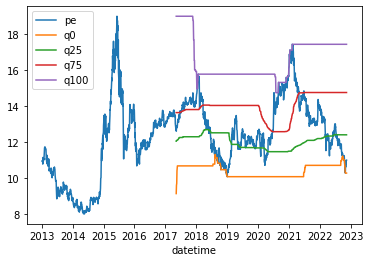

In [33]:
df[['pe', 'q0', 'q25', 'q75', 'q100']].plot()
plt.show()

### 定义策略

In [78]:
class TestStrategy(bt.Strategy):
    params = (
        ('pe', -1),
    )

    def log(self, txt, dt=None):
        ''' Logging function for this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.datape = self.datas[0].pe
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log(f'PE, {self.datape[0]:.2f}')
        self.log(f'Close, {self.dataclose[0]:.2f}')

### 回测初始化

In [86]:
# df.index = pd.to_datetime(df.index)
# df.index[0]
# df.columns
# df.head()

df.iloc[:, [-1]]

,pe
datetime,
2013-01-04,10.96
2013-01-07,10.97
2013-01-08,10.90
2013-01-09,10.90
2013-01-10,10.94
...,...
2022-11-08,10.88
2022-11-09,10.79
2022-11-10,10.74


In [79]:
cerebro = bt.Cerebro()

# 导入数据
datafeed = bt.feeds.PandasData(dataname=df, fromdate=dt.datetime(2013, 1, 1),
                                todate=dt.datetime(2022,1,1))
# datafeed = bt.feeds.PandasData(dataname=df, fromdate=datetime.datetime(2019,1,2), todate=datetime.datetime(2021,1,28))
cerebro.adddata(datafeed, name='hs300') # 通过 name 实现数据集与股票的一一对应
cerebro.broker.setcash(1000000)

# 增加策略
cerebro.addstrategy(TestStrategy)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 1000000.00


AttributeError: 'Lines_LineSeries_DataSeries_OHLC_OHLCDateTime_Abst' object has no attribute 'pe'